In [ ]:
# Notes:
#
# Why not use ICA instead of PCA? Would components be temporally independent? Probably not. Spatially then?


In [1]:
# Import data info
import scipy.io as sio
import numpy as np
import os

# atlas_root='/data1/vbeliveau/atlas'
# cluster_root=atlas_root + '/analyses/clustering'
# info_path=atlas_root + '/lists/info_alltracers_base_healthy_hrrt.mat'

MFA_data='C:/Users/vbeliveau/Documents/MFA_data'
info_path=cluster_root+'/data/info_alltracers_base_healthy_hrrt.mat'

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh','rh']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [97]:
# Sample TACs to fsaverage surface (currently done in Matlab, see MFApreproc.m)

In [96]:
# Preproc the raw data for MFA (currently done in Matlab, see MFApreproc.m)
# 
# 1) Perform SVD and identify eigenvalues
# 2) Stack data for left and right hemisphere
# 3) Standardize TACs (demean and divide by standard deviation)

In [66]:
# Create surface maps of MFA weigts

from nibabel import save, Nifti1Image
from sklearn.decomposition import PCA,TruncatedSVD

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='5'

Kmax=10 # Maximum number of components to consider

for tracer in tracers:
    # Load the data
    matfile=sio.loadmat(MFA_data + '/' + tracer + '/MFA.preproc.sm' + sm + '.mat')
    data=matfile['data'].flatten()
    N=data.shape[0]
    Nvert=data[0].shape[0]
    eig1=[eig[0] for eig in matfile['eigvals'].flatten()] # Extract first eigenval
    
    # Divide all datasets by first eigenval
    data_scaled=np.empty(N,dtype='O')
    for n in np.arange(0,N):
        data_scaled[n]=data[n]/eig1[n] # Consider multiplying by a large number before division to avoid numerical instabilities
    
    # Perform SVD on split 1 & 2, separately
    svd.fit(np.transpose(np.hstack(data_scaled[0:N])))
    U=np.transpose(svd.components_)
    
    # Import MFA weights
    tmp=sio.loadmat(MFA_data + '/' + tracer + '/MFA.preproc.sm0.mat')
    nlh=np.sum(tmp['lh_mask'])
    nrh=np.sum(tmp['rh_mask'])
    
    for hemi in ['lh']:
        # Select and transform hemi mask for indexing
        hemi_mask=tmp[hemi + '_mask'].flatten()==1
        wimg = hemi_mask.astype(np.int16)
        
        for nk in np.arange(0,Kmax):
            # Extract weight for specific hemisphere
            if hemi=='lh':
                W=U[0:nlh,nk] 
            else:
                W=MFAw['A'][nlh:(nlh+nrh),:]      

            # Save the clustering out as surface overlay

            wimg[hemi_mask] = W
            save(Nifti1Image(wimg, np.eye(4)), MFA_data + '/' + tracer + '/MFAw.' + hemi + '.k'+ str(nk) +'.nii')

In [20]:
# Compare components obtained with SVD and truncated SVD
# Here PCA is used as the gold standard (full, accurate decomposition)
# and truncated SVD is performed with some variations

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA,TruncatedSVD

tracer='cumi'

matfile=sio.loadmat(MFA_data + '/' + tracer + '/MFA.preproc.sm5.mat')
data=matfile['data'].flatten()
data=np.hstack(data[0:data.shape[0]]) # Use whole dataset

Kmax=20
U,S,V=np.linalg.svd(data,full_matrices=False)

def print_corr(A,B,Kmax):
    for i in np.arange(0,Kmax):
        cc=np.zeros(Kmax)
        for j in np.arange(0,Kmax):
            cc[j]=abs(np.dot(np.transpose(A[:,i]),B[:,j]))
        print 'Component ' + str(i+1) + ': %f' % np.max(cc)
    
# Trunk SVD from PCA
print 'Truncated SVD with PCA'
pca=PCA(n_components=Kmax)
pca.fit(np.transpose(data))
print_corr(np.transpose(pca.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with random the randomized algorithm (default)
print '\nTruncated SVD with randomized'
svd1=TruncatedSVD(n_components=Kmax)
svd1.fit(np.transpose(data))
print_corr(np.transpose(svd1.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with ARPACK algorithm
print '\nTruncated SVD with ARPACK'
svd2=TruncatedSVD(n_components=Kmax,algorithm='arpack')
svd2.fit(np.transpose(data))
print_corr(np.transpose(svd2.components_),U,Kmax)

Truncated SVD with PCA
Component 1: 0.998622
Component 2: 0.936784
Component 3: 0.983158
Component 4: 0.940455
Component 5: 0.984482
Component 6: 0.938392
Component 7: 0.995669
Component 8: 0.979724
Component 9: 0.910077
Component 10: 0.713230
Component 11: 0.672710
Component 12: 0.896943
Component 13: 0.942833
Component 14: 0.940509
Component 15: 0.745351
Component 16: 0.955188
Component 17: 0.559704
Component 18: 0.784443
Component 19: 0.580907
Component 20: 0.535580

Truncated SVD with randomized
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000
Component 4: 1.000000
Component 5: 1.000000
Component 6: 1.000000
Component 7: 1.000000
Component 8: 0.999999
Component 9: 0.999981
Component 10: 0.993051
Component 11: 0.990371
Component 12: 0.939935
Component 13: 0.902569
Component 14: 0.691657
Component 15: 0.814926
Component 16: 0.629688
Component 17: 0.344832
Component 18: 0.487870
Component 19: 0.526491
Component 20: 0.335161

Truncated SVD with ARPACK
Component 1: 1.00

In [ ]:
# Identify the number of components for Multitable FA by split-half resampling

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA,TruncatedSVD
import time

tracers=['az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='5'

Niter=100 # Number of split-half iterations (usually ~1000 or 10000)
Kmax=10 # Maximum number of components to consider

kf=KFold(n_splits=2) # Split-half model
cc={}
cc_null={}
for tracer in tracers:
    # Load the data
    matfile=sio.loadmat(MFA_data  + '/' + tracer + '/MFA.preproc.sm' + sm + '.mat')
    data=matfile['data'].flatten()
    N=data.shape[0]
    Nvert=data[0].shape[0]
    eig1=[eig[0] for eig in matfile['eigvals'].flatten()] # Extract first eigenval
    
    # Divide all datasets by first eigenval
    data_scaled=np.empty(N,dtype='O')
    for n in np.arange(0,N):
        data_scaled[n]=data[n]/eig1[n] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    cc=np.zeros([Niter,Kmax])
    cc_null=np.zeros([Niter,Kmax])
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')    
    start_t = time.time()
    print 'Processing ' + tracer
    for ni in np.arange(0,Niter): # Will need to parallelize this

        if ni % 100 == 0:
            print 'Iter ' + str(ni)
        
        # Get indices for current fold
        kf=KFold(n_splits=2,shuffle=True,random_state=ni) # State is explicitly defined for reproducibility
        split1,split2=kf.split(np.arange(0,N))
        
        # Perform SVD on split 1 & 2, separately
        svd.fit(np.transpose(np.hstack(data_scaled[split1[0]])))
        U1=np.transpose(svd.components_)
        svd.fit(np.transpose(np.hstack(data_scaled[split2[0]])))
        U2=np.transpose(svd.components_)
        
        # Compute component-wise correlations (absolute value, anx maximum accross all pairs)
        # NOTE: Consider also adding RV, CCA, ER and WER, as in Shams et al. (2015) Automated iterative reclustering framework for determining hierarchical functional networks in resting state fMRI. Hum Brain Mapp.
        for nk in np.arange(0,Kmax):
            cc[ni,nk]=np.abs(np.dot(np.transpose(U1[:,nk]),U2[:,nk]))
            
        # Shuffle vertices (spatial, rows) and repeat
        svd.fit(np.transpose(np.hstack(data_scaled[split1[0]])[np.random.permutation(Nvert),:]))
        U1=np.transpose(svd.components_)
        svd.fit(np.transpose(np.hstack(data_scaled[split2[0]])[np.random.permutation(Nvert),:]))
        U2=np.transpose(svd.components_)
        for nk in np.arange(0,Kmax):
            cc_null[ni,nk]=np.abs(np.dot(np.transpose(U1[:,nk]),U2[:,nk]))
    
    # Save results
    np.savetxt(MFA_data + '/' + tracer + '/split.half.CC.results.sm' + sm + '.dat',cc)
    np.savetxt(MFA_data + '/' + tracer + '/split.half.CC.null.results.sm' + sm + '.dat',cc_null)
    
    # Summarize results
    print 'CC mean'
    print np.mean(cc,axis=0)
    print 'CC null mean'
    print np.mean(cc_null,axis=0)
    print 'Elapsed time: %f' % (time.time()-start_t)

Processing az
Iter 0


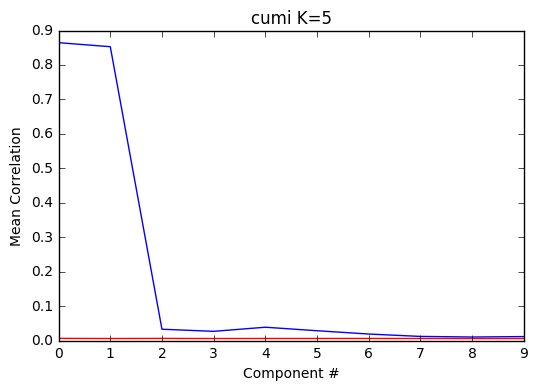

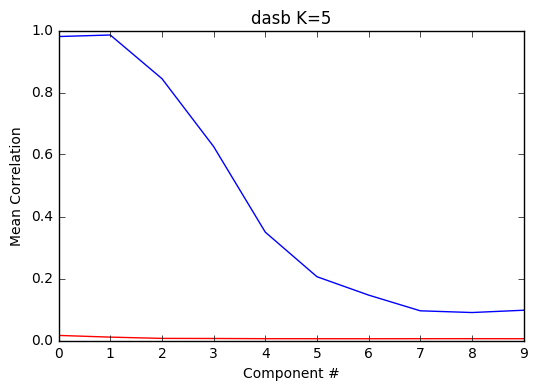

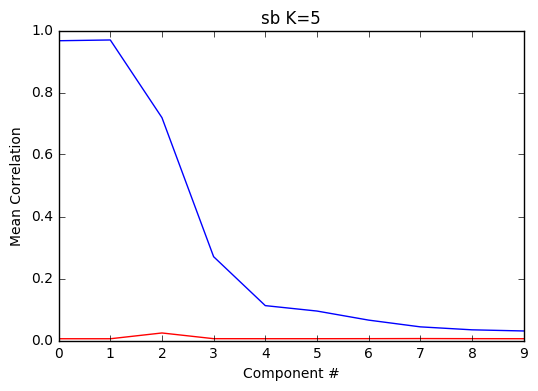

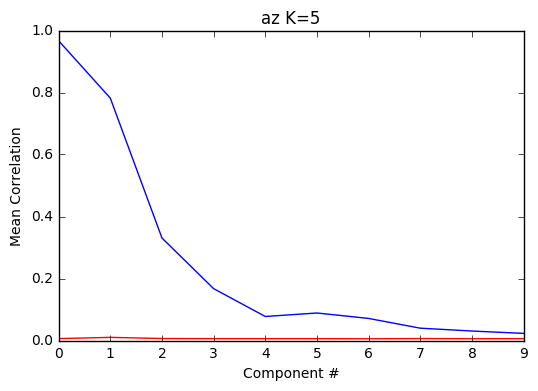

In [60]:
# Estimate number of significant components for each tracers

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# tracers=['cumi','dasb','sb','az','C36']
tracers=['cumi','dasb','sb','az']
sm='5'

plot_histo=False
for tracer in tracers:

    # Load split-half results
    cc=np.loadtxt(MFA_data + '/' + tracer + '/split.half.CC.results.sm' + sm + '.dat')
    cc_null=np.loadtxt(MFA_data + '/' + tracer + '/split.half.CC.null.results.sm' + sm + '.dat')
    Kmax=cc.shape[1]
    
    # Plot histograms of component K
    if plot_histo:
        for nk in np.arange(0,5):
            n, bins, patches = plt.hist(cc[:,nk], 100, normed=1, facecolor='red', alpha=0.75)
            n, bins, patches = plt.hist(cc_null[:,nk], 100, normed=1, facecolor='blue', alpha=0.75)
            plt.title(tracer + 'K=' + str(nk+1))
            plt.grid(True)
            plt.show()
    
    x=np.arange(0,cc.shape[1])
    plt.plot(x,np.mean(cc,axis=0),'b',x,np.mean(cc_null,axis=0),'r')
    plt.title(tracer)
    plt.xlabel('Component #')
    plt.ylabel('Mean Correlation')
    plt.show()
    
    # Use Mann-Whitney U test to determine the significance of each components uing CC
    pval=np.empty(Kmax)
    for nk in np.arange(0,Kmax):
        _,pval[nk]=mannwhitneyu(cc[:,nk],cc_null[:,nk])
        
#     print tracer + pval + ' components'

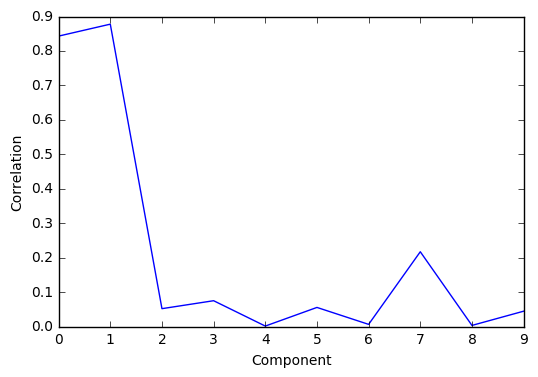

In [59]:
# Test the effect of selecting much less subjects for PCA decomposition for DASB

from sklearn.decomposition import TruncatedSVD

tracer='dasb'
sm='5'
Kmax=10
Nsubj=6

matfile=sio.loadmat(MFA_data + '/' + tracer + '/MFA.preproc.sm' + sm + '.mat')
data=matfile['data'].flatten()
N=data.shape[0]
Nvert=data[0].shape[0]
eig1=[eig[0] for eig in matfile['eigvals'].flatten()] # Extract first eigenval

# Divide all datasets by first eigenval
data_scaled=np.empty(N,dtype='O')
for n in np.arange(0,N):
    data_scaled[n]=data[n]/eig1[n] # Consider multiplying by a large number before division to avoid numerical instabilities

svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')    
svd.fit(np.transpose(np.hstack(data_scaled[0:Nsubj])))
U1=np.transpose(svd.components_)
svd.fit(np.transpose(np.hstack(data_scaled[Nsubj:2*Nsubj])))
U2=np.transpose(svd.components_)

cc=np.empty(Kmax)
for nk in np.arange(0,Kmax):
        cc[nk]=np.abs(np.dot(np.transpose(U1[:,nk]),U2[:,nk]))
        
plt.plot(np.arange(0,Kmax),cc,'b')
plt.xlabel('Component')
plt.ylabel('Correlation')
plt.show()

In [ ]:
# Make final decomposition

tracers=['cumi','dasb','sb','az','C36']

for tracer in tracers:
    # Load the data
    matfile=sio.loadmat(MFA_data + '/' + tracer + '/MFA.preproc.sm' + sm + '.mat')
    data=matfile['data'].flatten()
    N=data.shape[0]
    Nvert=data[0].shape[0]
    eig1=[eig[0] for eig in matfile['eigvals'].flatten()] # Extract first eigenval
    
    # Divide all datasets by first eigenval
    data_scaled=np.empty(N,dtype='O')
    for n in np.arange(0,N):
        data_scaled[n]=data[n]/eig1[n]
        
    U,S,V=np.linalg.svd(np.hstack(data_scaled[split1[0]]))
    
    out=np.readtxt()
    MFAw=U[0][:,Kopt]
    np.savetxt(MFA_data + '/' +  tracer + '/MFAw.sm0.mat')

In [14]:
# Cluster MFA weights per tracer, and as a whole, using Aglomerative clustering tree with Ward's and spatial constraint

import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from nibabel import save, Nifti1Image

# Perform Ward clustering for single tracer data
for tracer in ['cumi']:
    # Import MFA weights
    MFAw=sio.loadmat(MFA_data + '/' + tracer + '/test.mat')
    tmp=sio.loadmat(MFA_data + '/' + tacer '/MFA.preproc.sm0.mat')
    nlh=np.sum(tmp['lh_mask'])
    nrh=np.sum(tmp['rh_mask'])
    
    for hemi in ['lh']:
        # Select and transform hemi mask for indexing
        hemi_mask=tmp[hemi + '_mask'].flatten()==1
        
        # Import adjacency matrix and only keep elements in surface mask
        A=sio.loadmat(cluster_root + '/data/adjacency.fsaverage5.' + hemi + '.mat')
        A=A['A'][np.ix_(hemi_mask,hemi_mask)]
        
        # Extract weight for specific hemisphere
        if hemi=='lh':
            W=MFAw['A'][0:nlh,:] 
        else:
            W=MFAw['A'][nlh:(nlh+nrh),:]      
        
        # NOTE: Change this into cross-validation for estimating number of clusters
        ch=[]
        sil=[]        
        K_range=np.arange(2,25)
        for nk in K_range:
            
            mdl=AgglomerativeClustering(n_clusters=nk, connectivity=A,linkage='ward')
            mdl.fit(W)
            C=mdl.labels_+1
            
            # Evaluate some clustering indexes
            ch.append(metrics.calinski_harabaz_score(W, C))
            sil.append(metrics.silhouette_score(W, C))

            # Save the clustering out as surface overlay
            wlabel = hemi_mask.astype(np.int16)
            wlabel[hemi_mask] = C
            save(Nifti1Image(wlabel, np.eye(4)), MFA_data '/' + tracer + '/ward.' + hemi + '.k'+ str(nk) +'.nii')
            

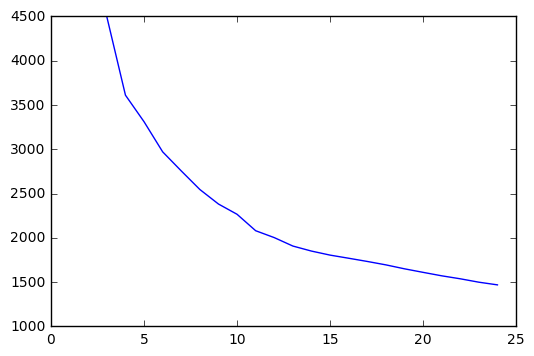

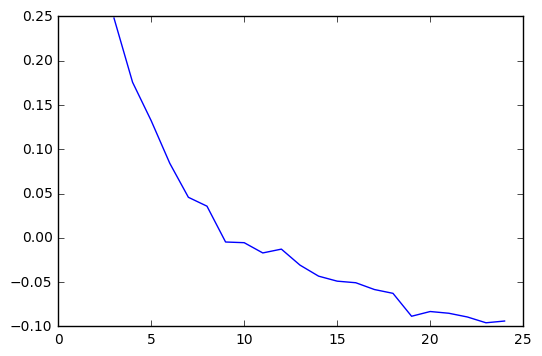

In [12]:
import matplotlib.pyplot as plt
plt.plot(K_range,ch)
plt.show()
plt.plot(K_range,sil)
plt.show()